# Import

In [1]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import plotly
plotly.offline.init_notebook_mode()

In [2]:
from file_py.run_log_parser import RunLogParser
from file_py.csv_preprocessing_scaler import CsvPreprocessingScaler

from file_py.plots import Plots

from file_py.utils import MarkdownHelper

from file_py.attack_log_unification import AttackLogUnification
from file_py.stat_severity import StatSeverity
from file_py.attack_pattern_analyzer import AttackPatternAnalyzer
from file_py.signatures_patterns import SignaturePatterns

from file_py.signature_stats_calculator import SignatureStatsCalculator
from file_py.sigma_rule_analysis import SigmaRuleAnalysis

from file_py.plots_single_attack import PlotsSingleAttack

from file_py.correlation_matrix_plots import CorrelationMatrixPlots

from file_py.preprocessing_train_test_split import PreprocessingTrainTestSplit
from file_py.initial_training import InitialTraining
from file_py.hyperparameter_tuning import HyperparameterTuning
from file_py.advanced_models import AdvancedModels
from file_py.deep_learning_model import DeepLearningModel
from file_py.model_evaluator import ModelEvaluator

# CARICAMENTO FILE

Sostituire il percorso dei file attuali con il percorso dei file di interesse qui:

In [3]:
# FILE CONTENENTE I LOG
df = CsvPreprocessingScaler.read_csv_file("file_csv/LogSplunkWF_03_07.csv")

# FILE CON LE DATE DI INIZIO E FINE DEGLI ATTACCHI
files = ['file_csv/attackLog_03_07.csv']

# Preprocessing

In [4]:
df_raw = CsvPreprocessingScaler.RawPreprocessing(df)
df_Le = CsvPreprocessingScaler.LEPreprocessing(df)
df_OH = CsvPreprocessingScaler.OhePreprocessing(df)

In [5]:
df_std_LE = CsvPreprocessingScaler.stdScaler(CsvPreprocessingScaler.LEPreprocessing(df))
df_std_OH = CsvPreprocessingScaler.stdScaler(CsvPreprocessingScaler.OhePreprocessing(df))

# Test

In [6]:
attack_log_path = AttackLogUnification.attack_log_together(files,'file_csv/attackLog_03_07.csv')

In [7]:
result_df_Le = RunLogParser.process_attacks(attack_log_path, CsvPreprocessingScaler.stdScaler(CsvPreprocessingScaler.LEPreprocessing(df)))
result_df_OH = RunLogParser.process_attacks(attack_log_path, CsvPreprocessingScaler.stdScaler(CsvPreprocessingScaler.OhePreprocessing(df)))
result_df_Raw = RunLogParser.process_attacks(attack_log_path, CsvPreprocessingScaler.RawPreprocessing(df))

# Graphic Analysis of Attacks

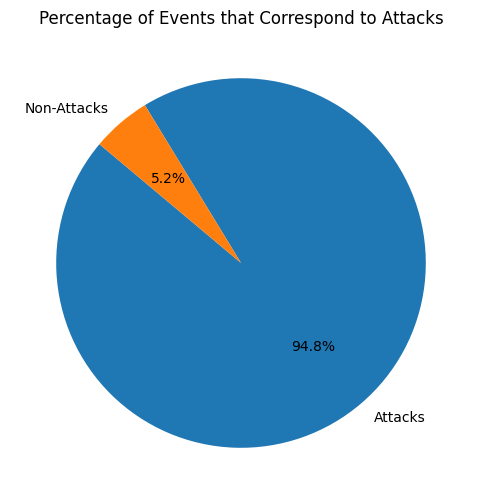

In [8]:
Plots.plot_cake_attack(result_df_Raw)

In [9]:
Plots.plot_top_10_signatures(result_df_Raw)

alt.VConcatChart(...)

Qui si può notare come generalmente le __regole scattate più volte__ sono anche quelle che hanno effettivamente __risposto a più attachi__ e che sono **scattate a vuoto più volte**.  

In [10]:
Plots.plot_precision_recall(result_df_Raw)

alt.VConcatChart(...)

Il *primo grafico* mostra la **precisione** di ciascuna regola, cioè la proporzione di **attivazioni corrette** rispetto al **totale delle sue attivazioni**.  
Una precisione più *alta* indica che la regola è *più accurata* nel rilevare veri attacchi.

Il *secondo grafico* mostra il **recall**, cioè la proporzione di **attacchi reali rilevati dalla regola** rispetto al **totale degli attacchi reali**.  
Un recall più *alto* indica che la regola è *più efficace* nel rilevare tutti gli attacchi possibili.

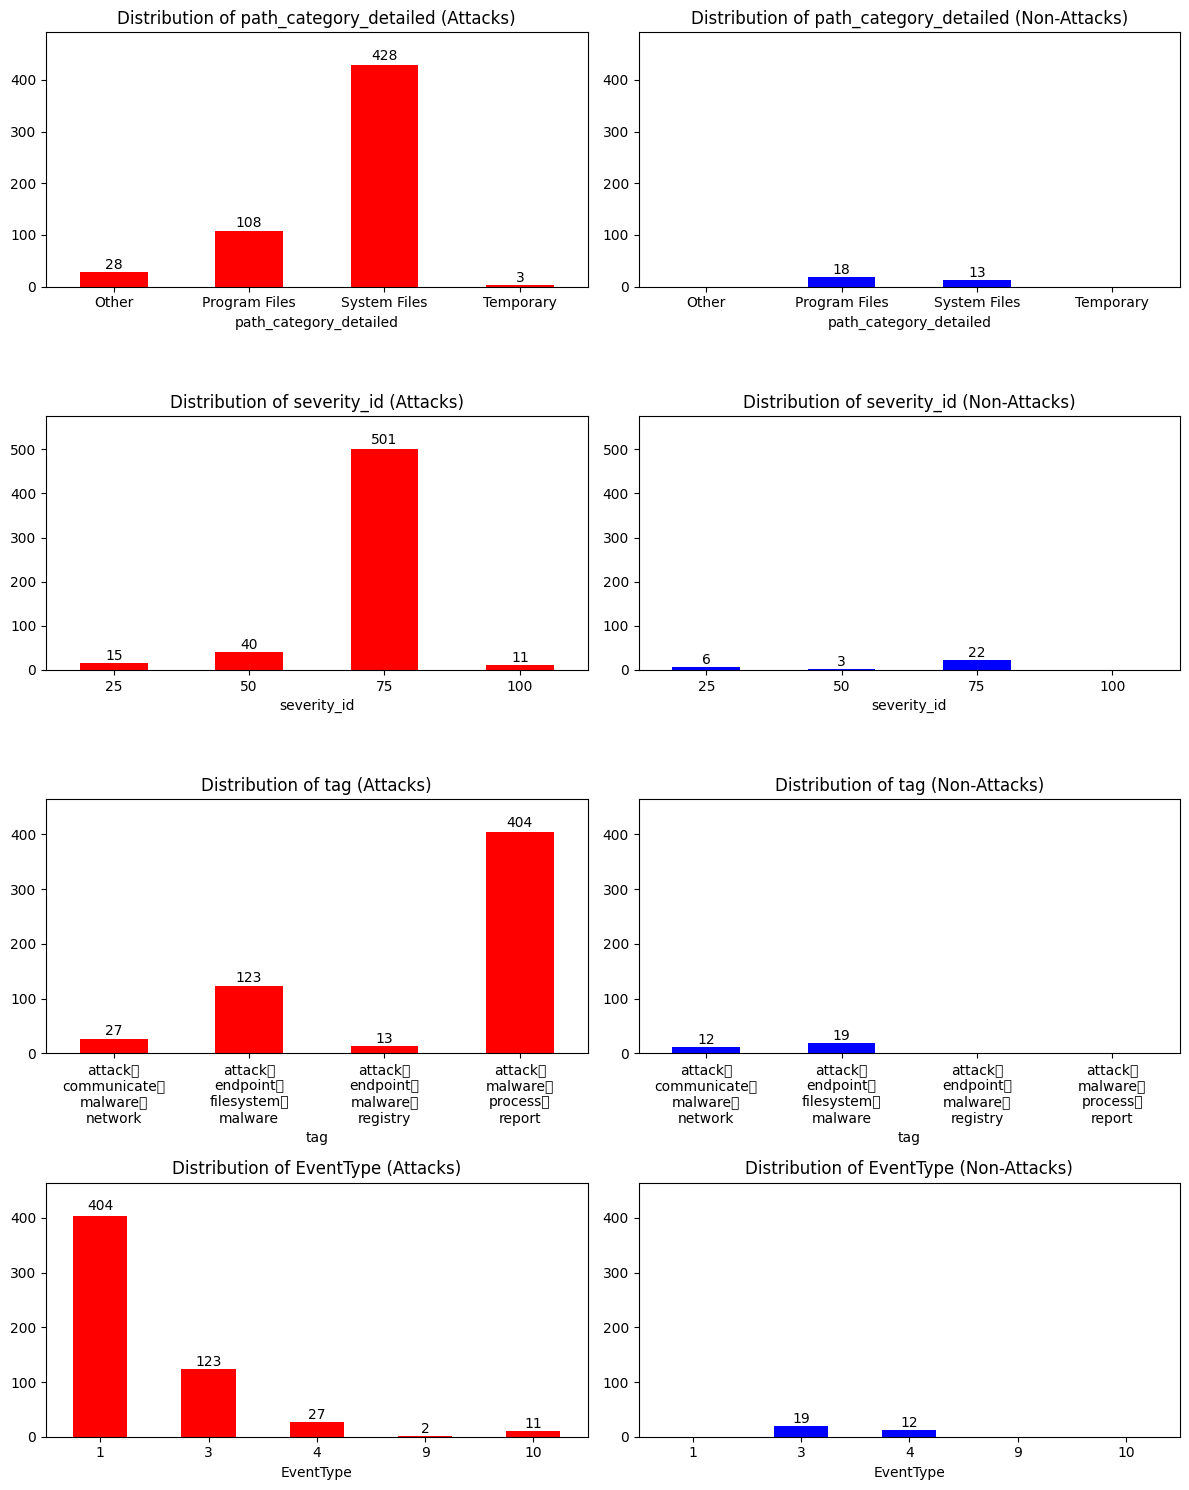

In [11]:
Plots.plot_distributions(result_df_Raw)

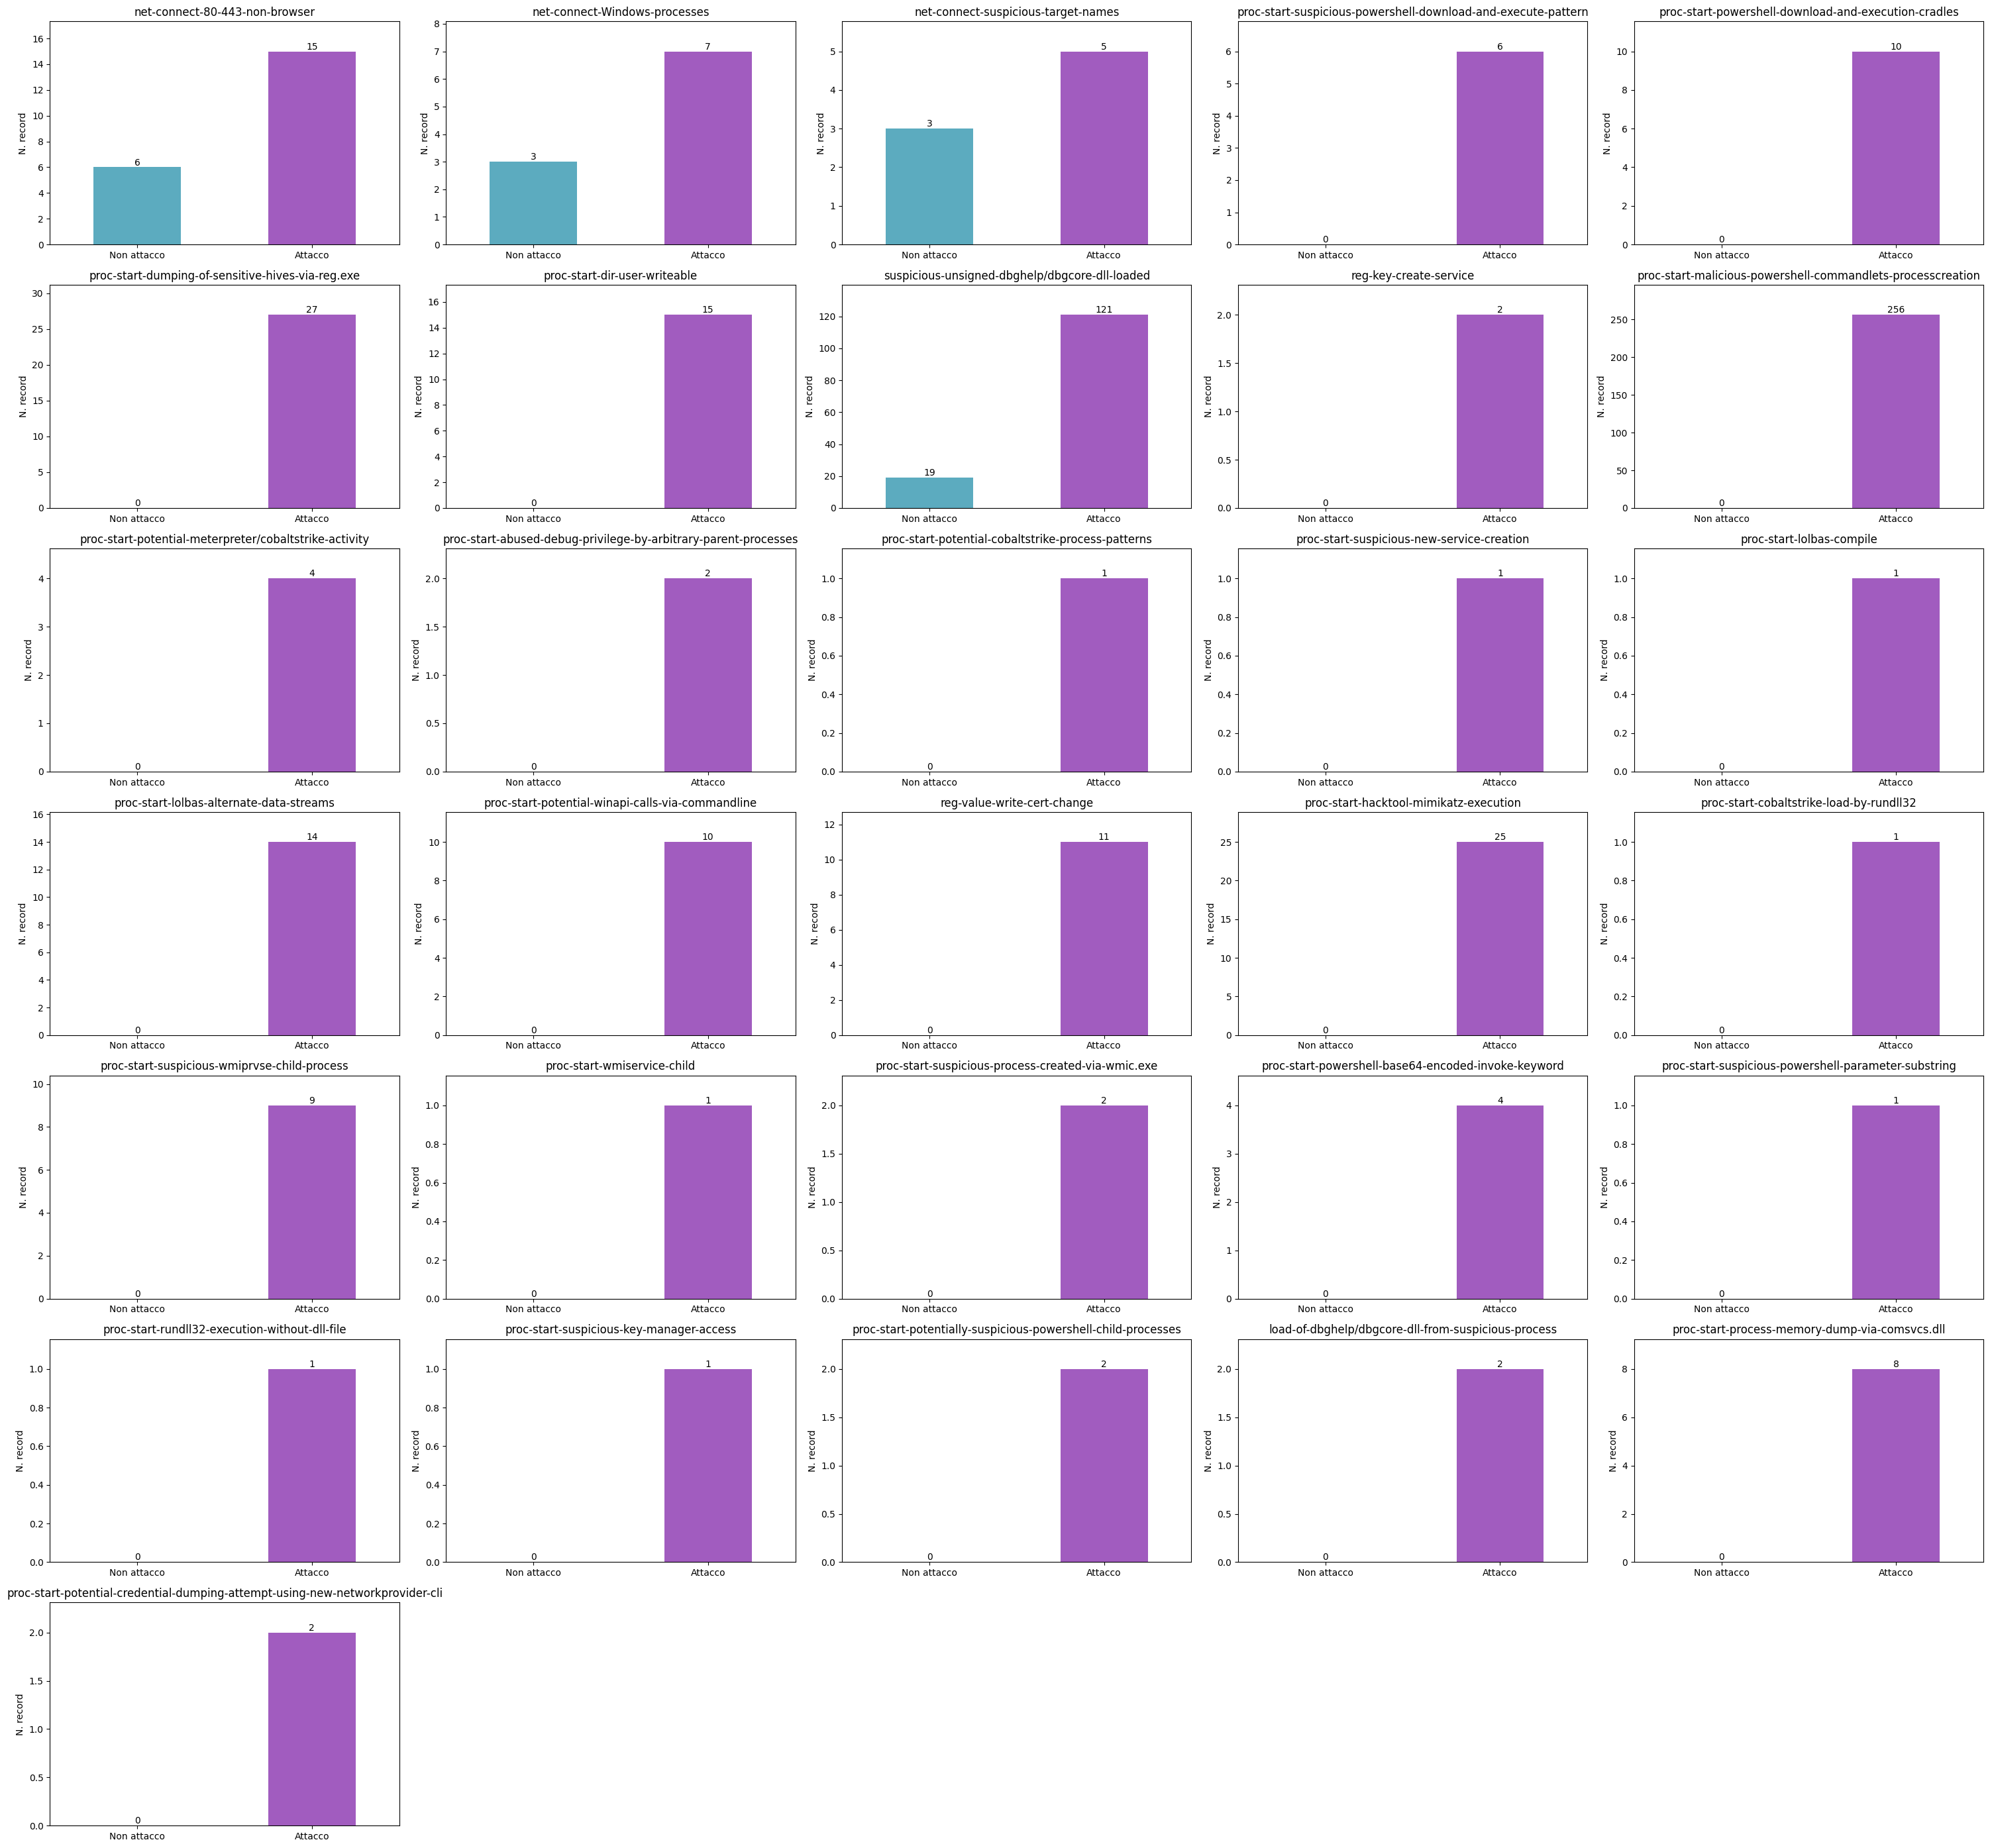

In [12]:
Plots.plot_value_counts_per_unique(result_df_Raw)

In [13]:
variables = MarkdownHelper.create_value_counts_variables(result_df_Raw)
MarkdownHelper.display_value_counts_text(variables)

<h5>Grazie a questo grafico invece possiamo giungere ad una serie di conclusioni.

Su **31** regole diverse:

- quelle scattate in risposta ad ALMENO un **attacco reale** sono **31**.
  Di queste:
  - **0** si sono attivate più volte per **non-attacchi** rispetto che per gli attacchi. (*regole generiche*)
  - **0** si sono attivate lo **stesso numero** di volte per attacchi e non-attacchi.
  - **31** si sono attivate più volte in risposta ad **attacchi** rispetto che a non-attacchi (*regole specifiche*).

- quelle scattate **senza rispondere mai ad attacchi** sono **0**.

  **Si tratta di**: []</h5>

# Analysis of Severity per Attacks

In [14]:
event_df = RunLogParser.create_event_df(attack_log_path, result_df_Raw)

Creazione del df **event_df** con le nuove colonne *severity_max, _min, _mean*

## Grafici

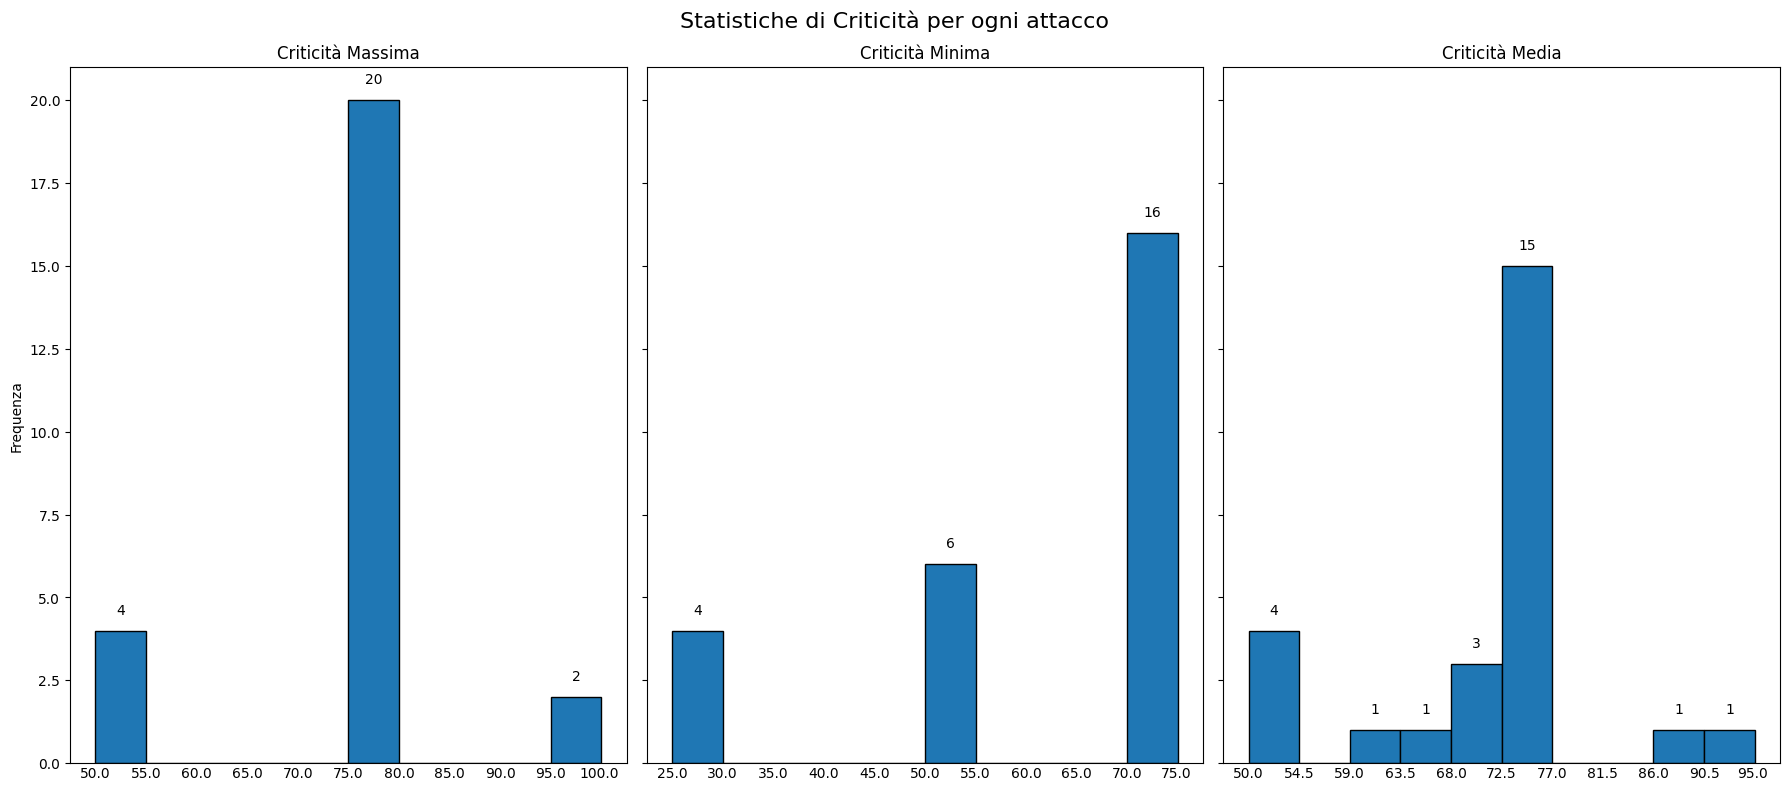

In [15]:
StatSeverity.plot_stat_severity(event_df)

In questo grafico vediamo, per **ciascun attacco** presente nel dataset, quali sono le loro **criticità** *massime, minime e medie*.

In [16]:
analyzer = AttackPatternAnalyzer(event_df)

In [17]:
# SCEGLIERE UN VALORE PER LA SEVERITY DELLE REGOLE DA CONSIDERARE
severity_value=73

# SCEGLIERE IL NUMERO DI ATTACCHI DA CONSIDERARE PRIMA DELLE REGOLE AVENTI LA SEVERITY SCELTA
num_attacks=10

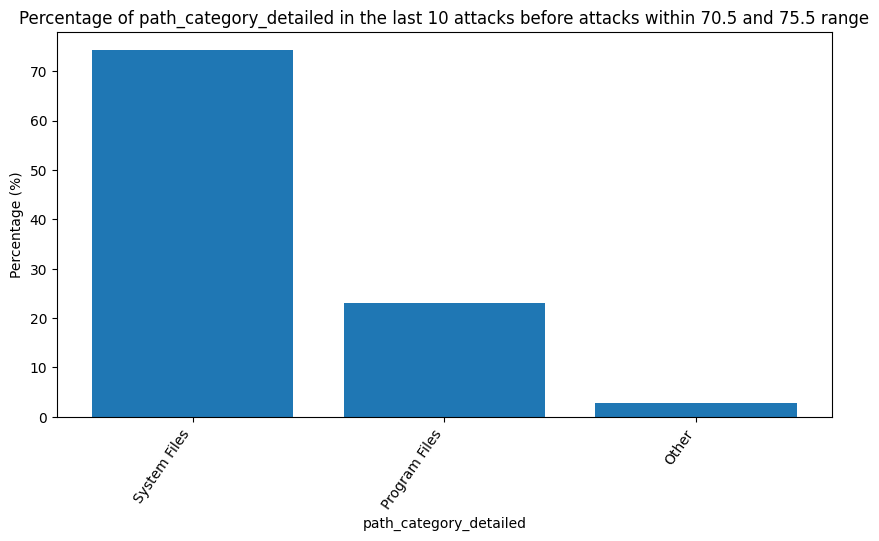

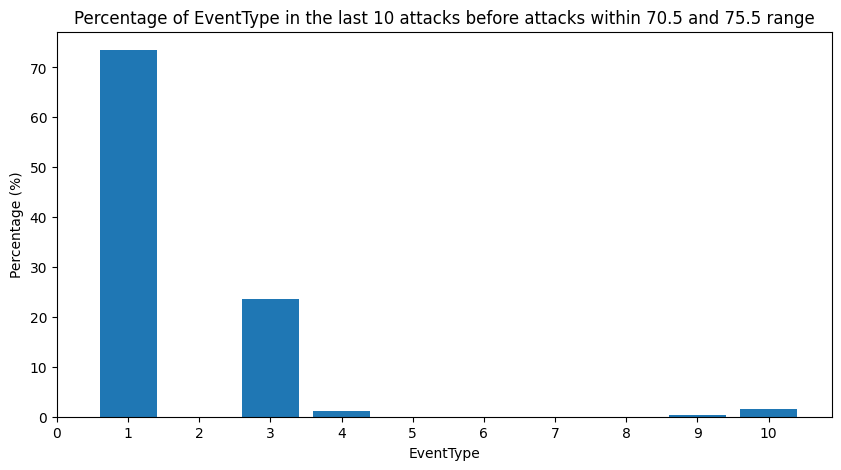

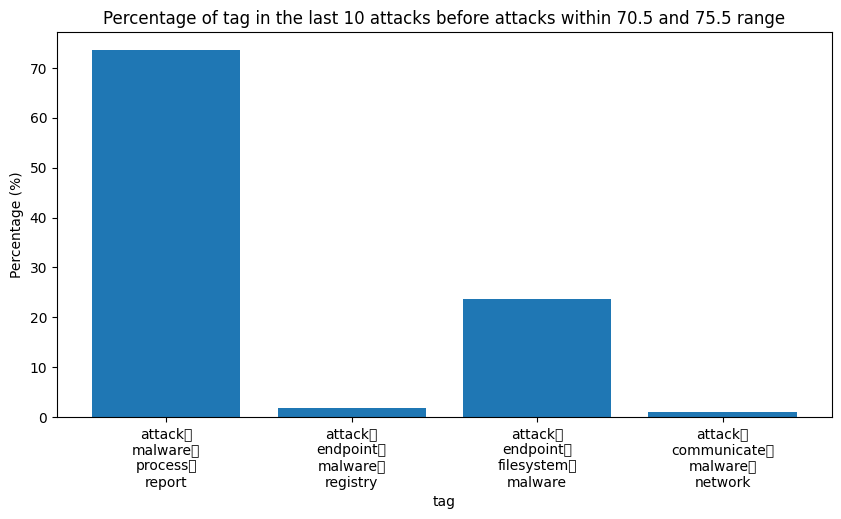

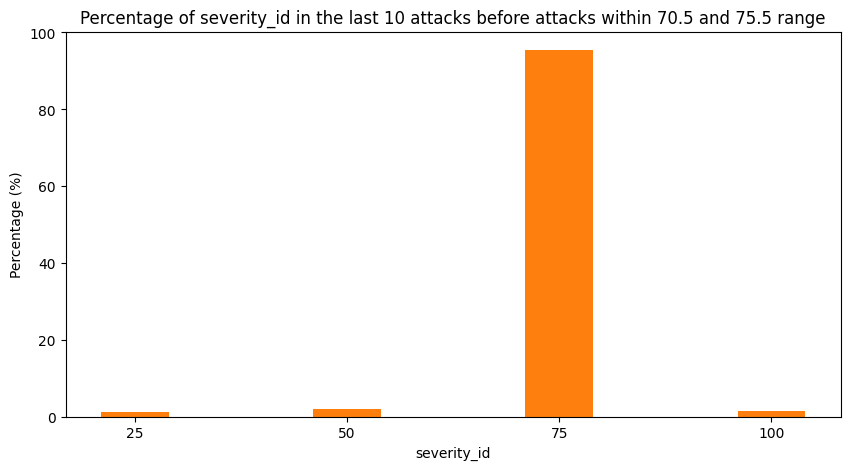

In [18]:
analyzer.pattern_before_attack(num_attacks=num_attacks, severity_value=severity_value)

In questi grafici prendiamo in considerazione gli **attacchi precedenti** a *tutti gli attacchi* che hanno una **certa criticità media** e *visualizziamo* tutti i valori di "**RuleAnnotation.mitre_attack.id**", "**signature**", "**EventType**", "**tag**", "**severity_id**" corrispondenti.

Per scegliere **quanti attacchi prima** *di quelli che ci interessano* vogliamo considerare basta modificare la variabile "**num_attacks**" e assegnarle il numero che vogliamo,  
mentre per scegliere il **valore della criticità media** che ci interessa si deve modificare la variabile "**severity_value**".  
Verranno presi in considerazione tutti gli attacchi con *criticità media compresa* tra **2.5 prima** e **2.5 dopo** del valore assegnato a "severity_value".

## Robustezza regole

In [19]:
signature_stats = SignatureStatsCalculator.create_signature_stats(event_df, result_df_Raw)
signature_stats

signature  Indice_Diff  \
0                      net-connect-80-443-non-browser     0.026178   
1                       net-connect-Windows-processes     0.002101   
2                 net-connect-suspicious-target-names     0.001212   
3   proc-start-suspicious-powershell-download-and-...     0.005523   
4   proc-start-powershell-download-and-execution-c...     0.007495   
5   proc-start-dumping-of-sensitive-hives-via-reg.exe     0.002637   
6                       proc-start-dir-user-writeable     0.023308   
7      suspicious-unsigned-dbghelp/dbgcore-dll-loaded     0.045368   
8                              reg-key-create-service     0.002792   
9   proc-start-malicious-powershell-commandlets-pr...     0.013459   
10  proc-start-potential-meterpreter/cobaltstrike-...     0.000770   
11  proc-start-abused-debug-privilege-by-arbitrary...     0.000562   
12  proc-start-potential-cobaltstrike-process-patt...     0.000370   
13         proc-start-suspicious-new-service-creation     0.000562   
14                          proc-start-lolbas-compile     0.000000   
15           proc-start-lolbas-alternate-data-streams     0.000000   
16  proc-start-potential-winapi-calls-via-commandline     0.015191   
17                        reg-value-write-cert-change     0.022747   
18             proc-start-hacktool-mimikatz-execution     0.000000   
19           proc-start-cobaltstrike-load-by-rundll32     0.000000   
20       proc-start-suspicious-wmiprvse-child-process     0.000000   
21                        proc-start-wmiservice-child     0.000000   
22  proc-start-suspicious-process-created-via-wmic...     0.000000   
23  proc-start-powershell-base64-encoded-invoke-ke...     0.000000   
24  proc-start-suspicious-powershell-parameter-sub...     0.000000   
25     proc-start-rundll32-execution-without-dll-file     0.001923   
26           proc-start-suspicious-key-manager-access     0.001923   
27  proc-start-potentially-suspicious-powershell-c...     0.001923   
28  load-of-dbghelp/dbgcore-dll-from-suspicious-pr...     0.000000   
29     proc-start-process-memory-dump-via-comsvcs.dll     0.004006   
30  proc-start-potential-credential-dumping-attemp...     0.002564   

    Media_Differenza_Severity_min  Media_Differenza_Severity_mean  \
0                       -4.807692                       -0.692819   
1                        0.000000                       -0.121006   
2                        0.000000                        0.148516   
3                        0.000000                        0.148516   
4                        0.000000                        0.175519   
5                        0.000000                        0.545410   
6                       -3.125000                       -0.893017   
7                       -1.041667                        3.040575   
8                        0.000000                       -0.025202   
9                        0.000000                        0.000000   
10                       0.000000                        0.000000   
11                       0.000000                        0.000000   
12                       0.000000                        0.000000   
13                       0.000000                        0.000000   
14                       0.000000                        0.000000   
15                       0.000000                        0.000000   
16                       0.000000                        0.694444   
17                       0.000000                        2.264957   
18                       0.000000                        0.000000   
19                       0.000000                        0.000000   
20                       0.000000                        0.000000   
21                       0.000000                        0.000000   
22                       0.000000                        0.000000   
23                       0.000000                        0.000000   
24                       0.000000                        0.000000   
25       

**signature_stats** è un dataset in cui possiamo vedere per **ogni regola** se venisse **rimossa** *quali cambiamenti* di **severity** apporterebbe al *dataset dei log* e se ci dovessero essere degli **attacchi** che **non** vengono **rilevati**.

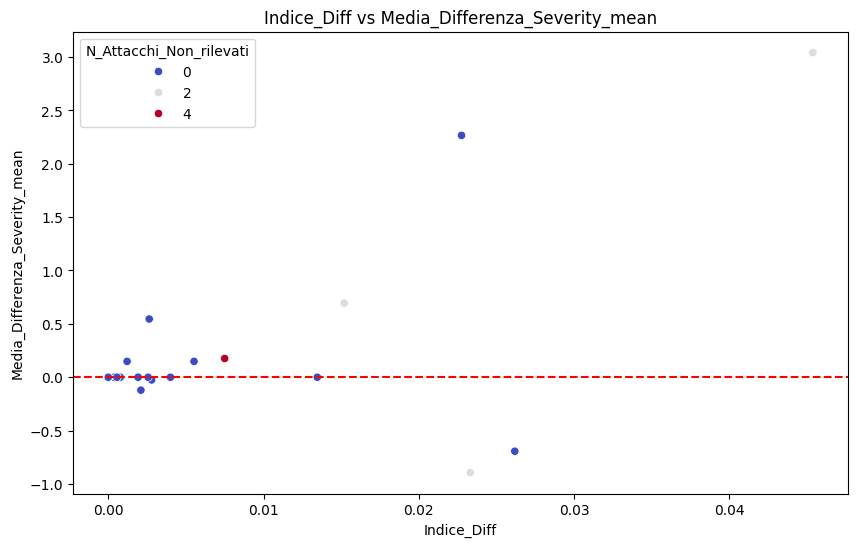

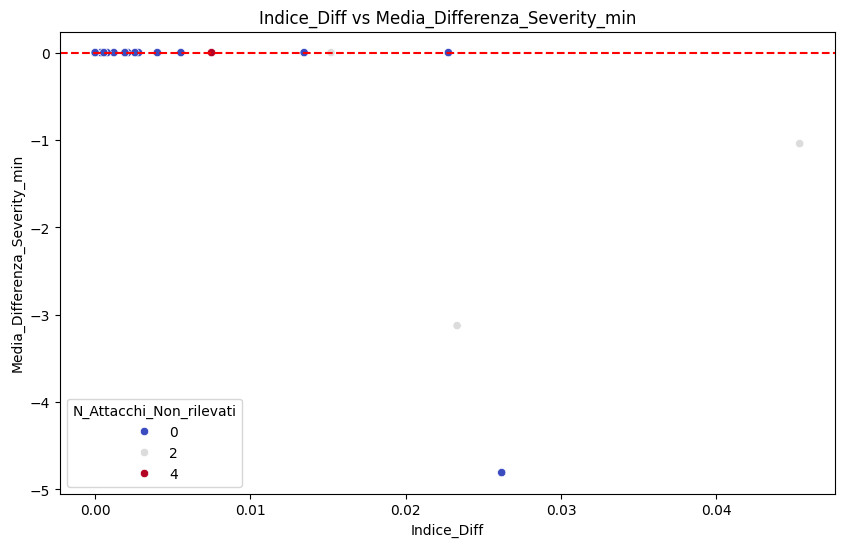

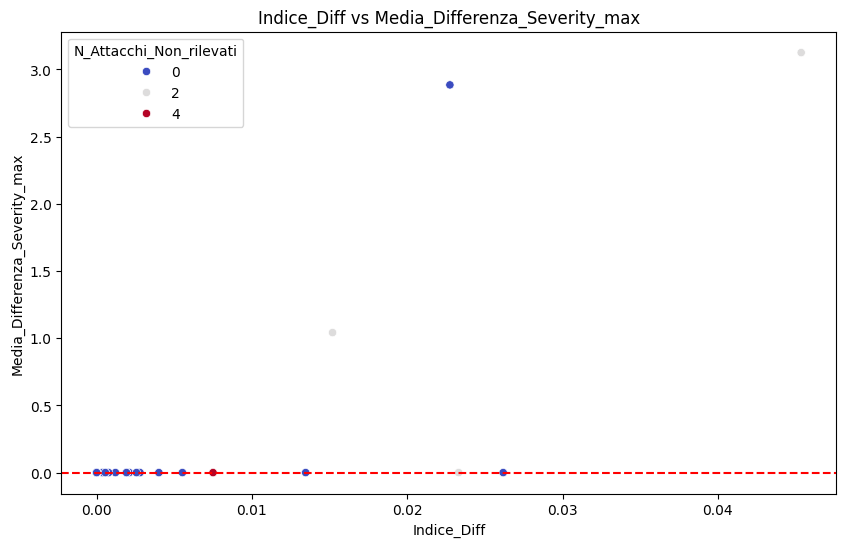

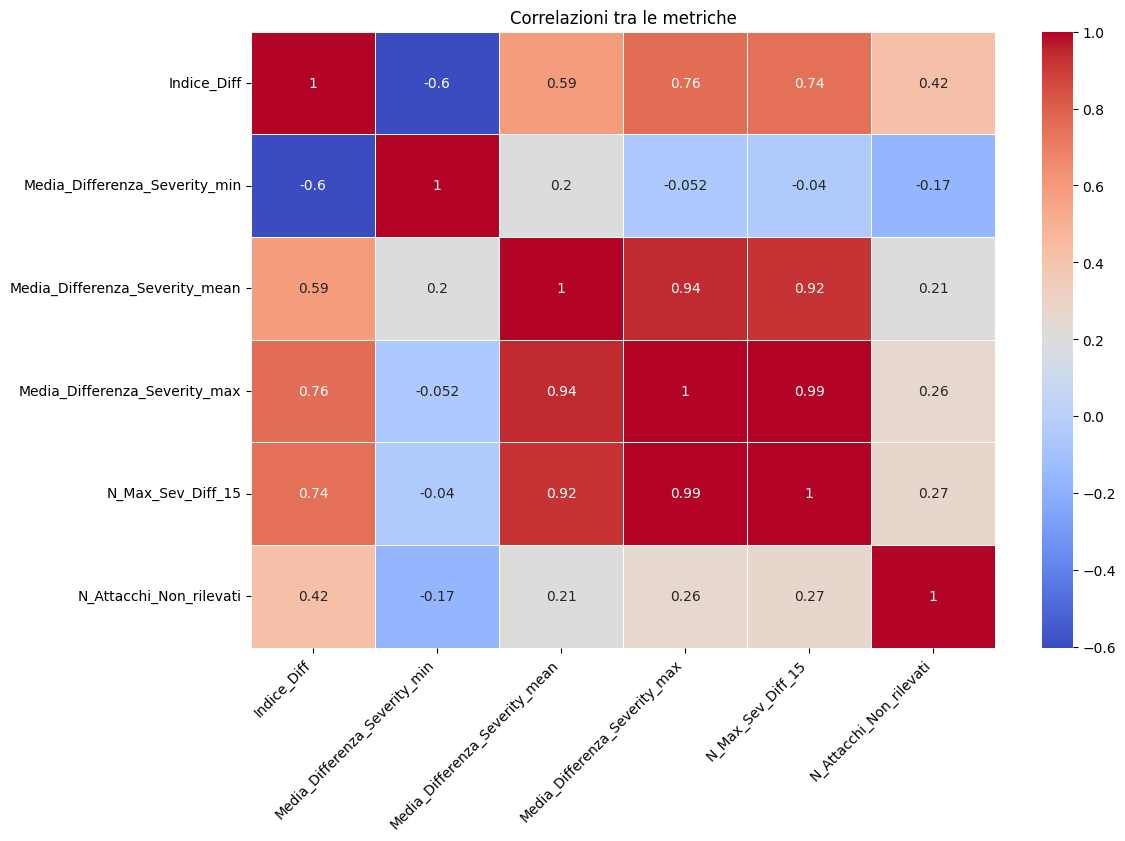

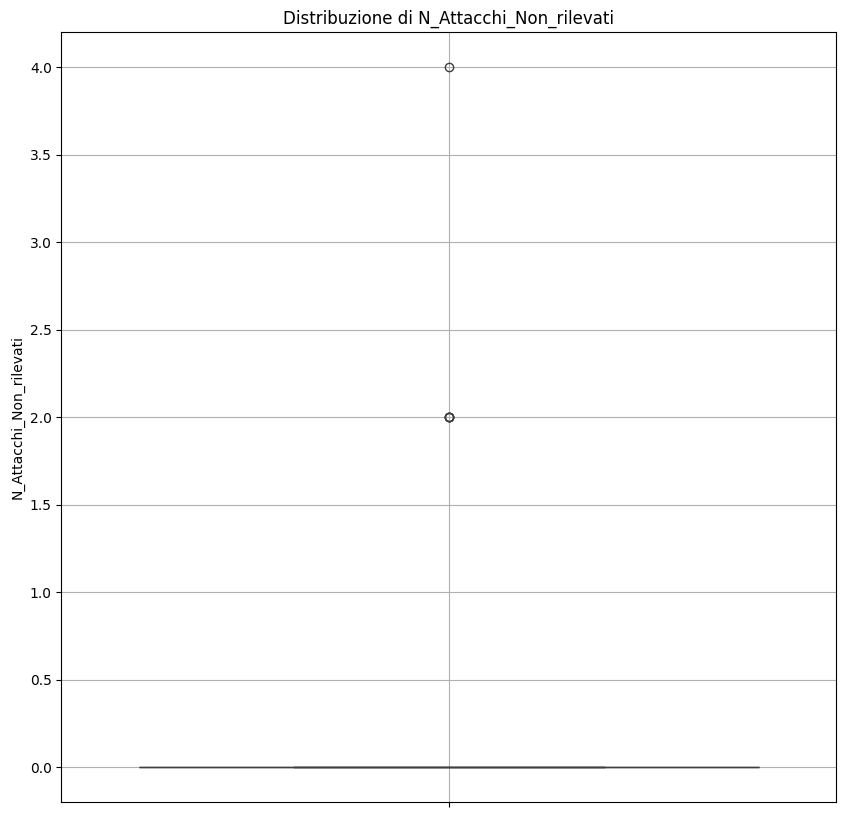

In [20]:
analysis = SigmaRuleAnalysis(signature_stats)
analysis.plots_sigma_rule_analysis()

# Graphic Analysis of Attacks for Chosen Rule

In [21]:
# SCEGLIERE LA REGOLA CHE SI VUOLE ANALIZZARE
regola_scelta = 'suspicious-unsigned-dbghelp/dbgcore-dll-loaded'

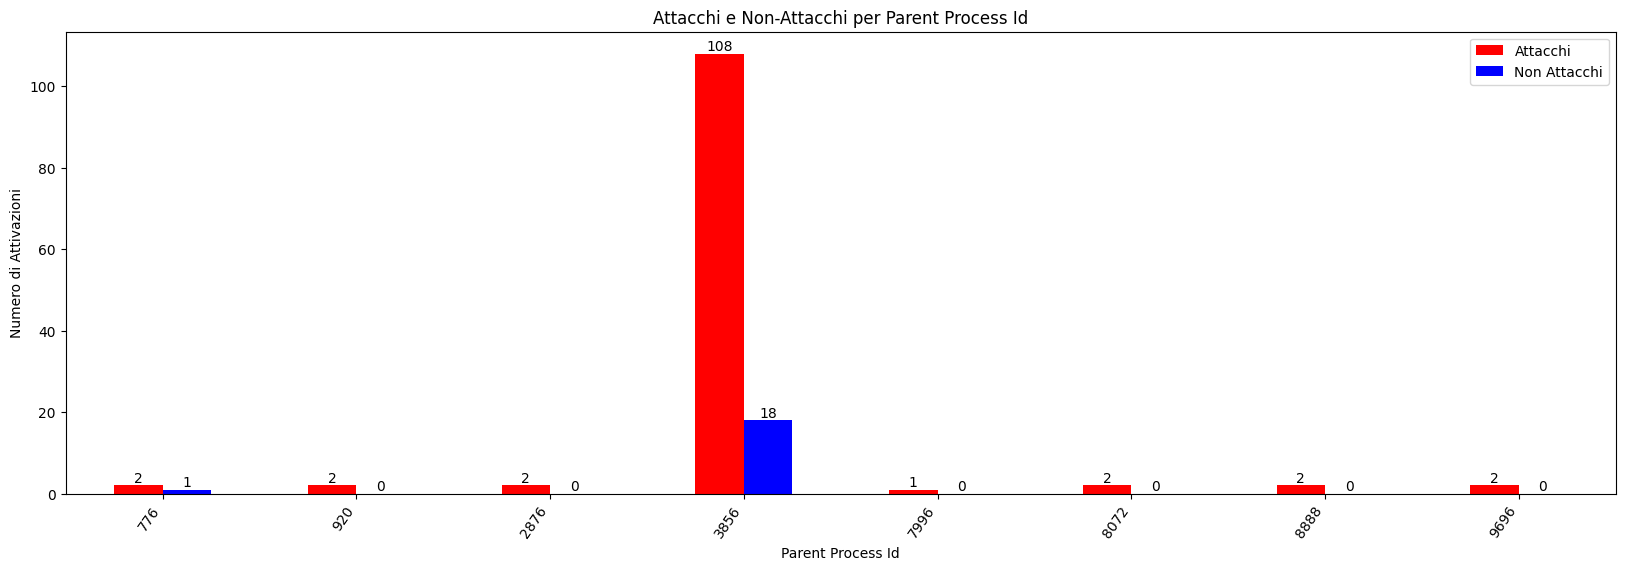

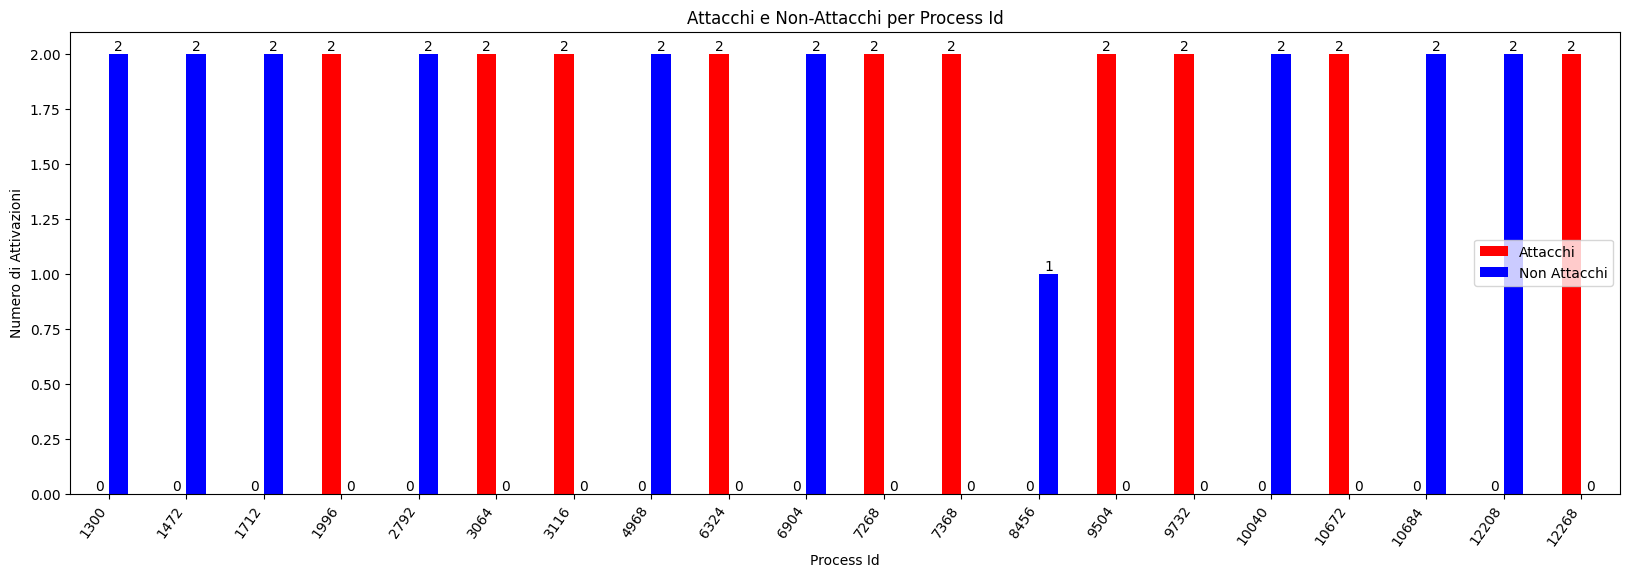

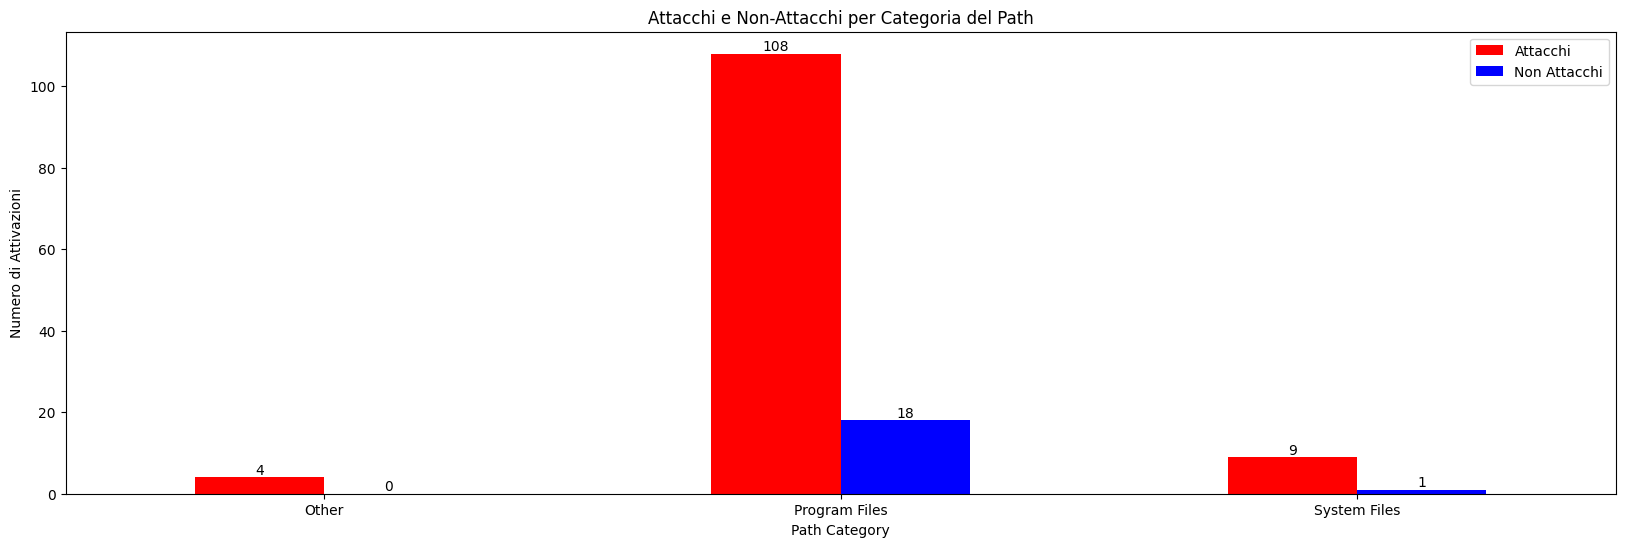

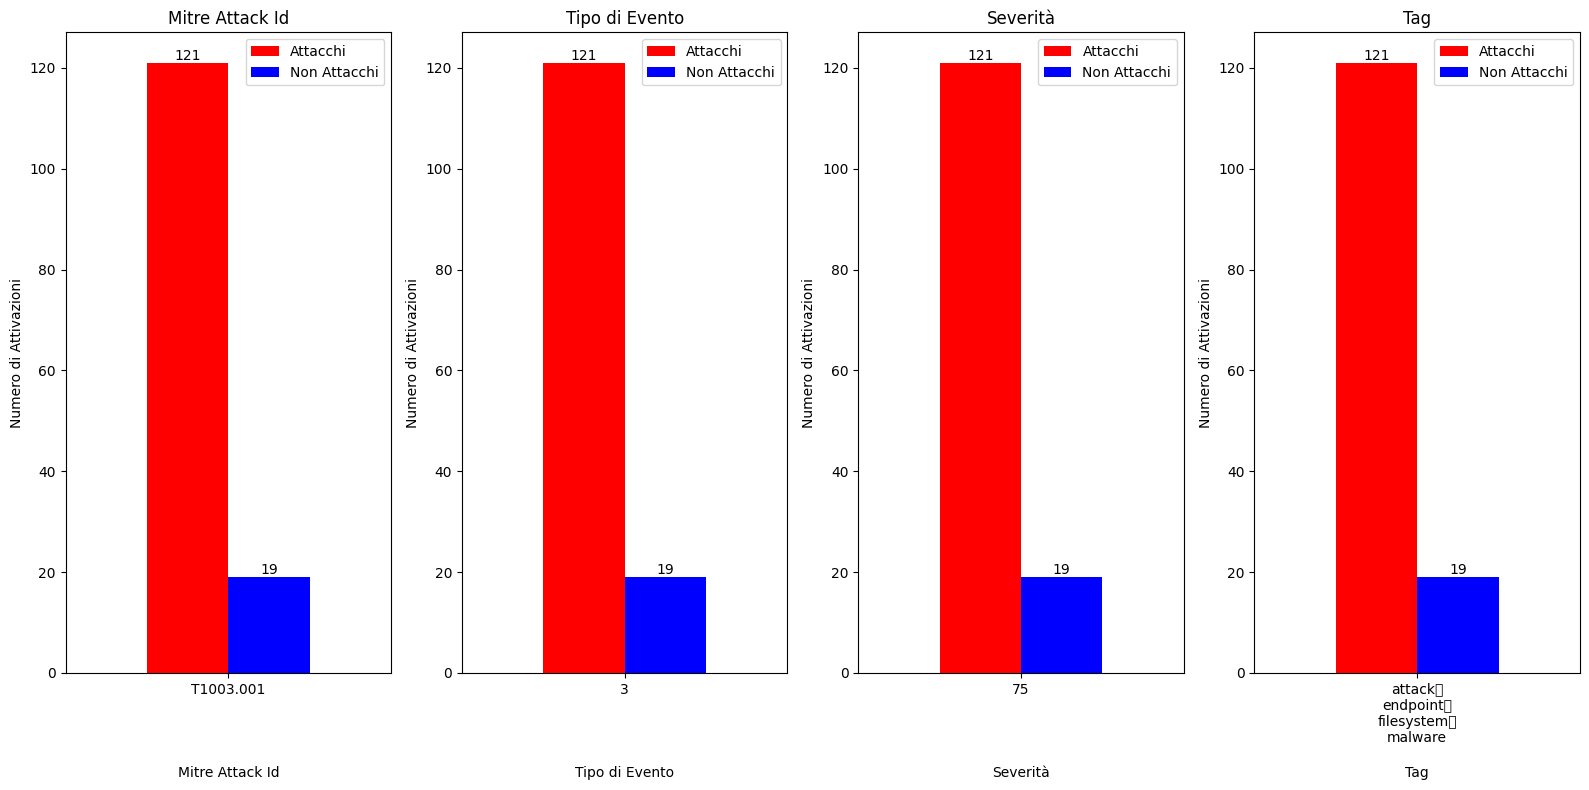

In [22]:
PlotsSingleAttack.analyze_rule_activations(result_df_Raw, regola_scelta)

In questi grafici in base alla **regola che si vuole analizzare** possiamo visualizzare:
- la **frequenza delle attivazioni** delle regole (attacchi e non attacchi) suddivise in intervalli di *5 minuti*;
- gli **attacchi e i non-attacchi** in base a:
    - *RuleAnnotation.mitre_attack.id*
    - *EventType*,
    - *severity*,
    - *tag*
    - *parent_process_id*,
    - *process_id*

In [23]:
# SCEGLIERE IL NUMERO DI EVENTI PRECEDENTI ALLA REGOLA CHE SI VOGLIONO ANALIZZARE
eventi_da_considerare = 5

alt.Chart(...)

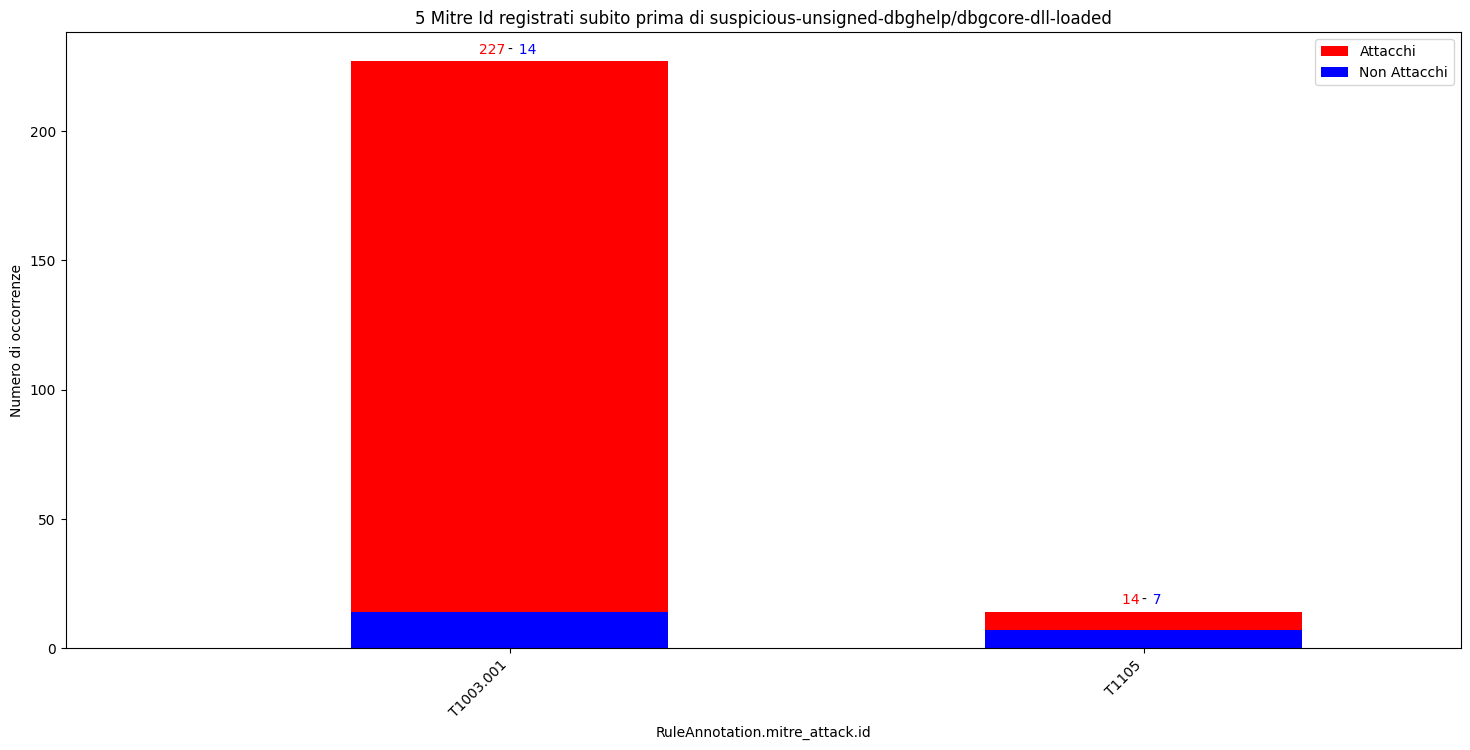

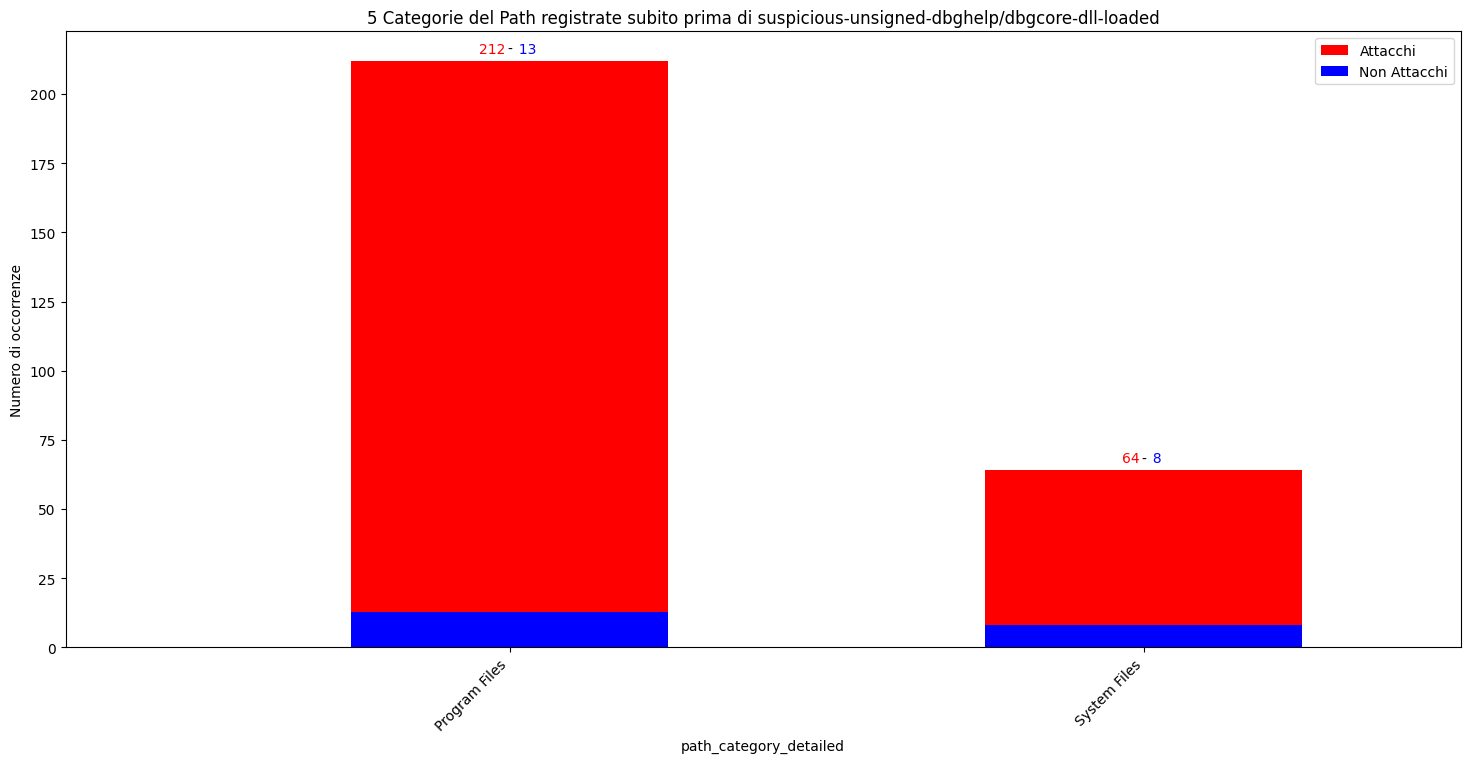

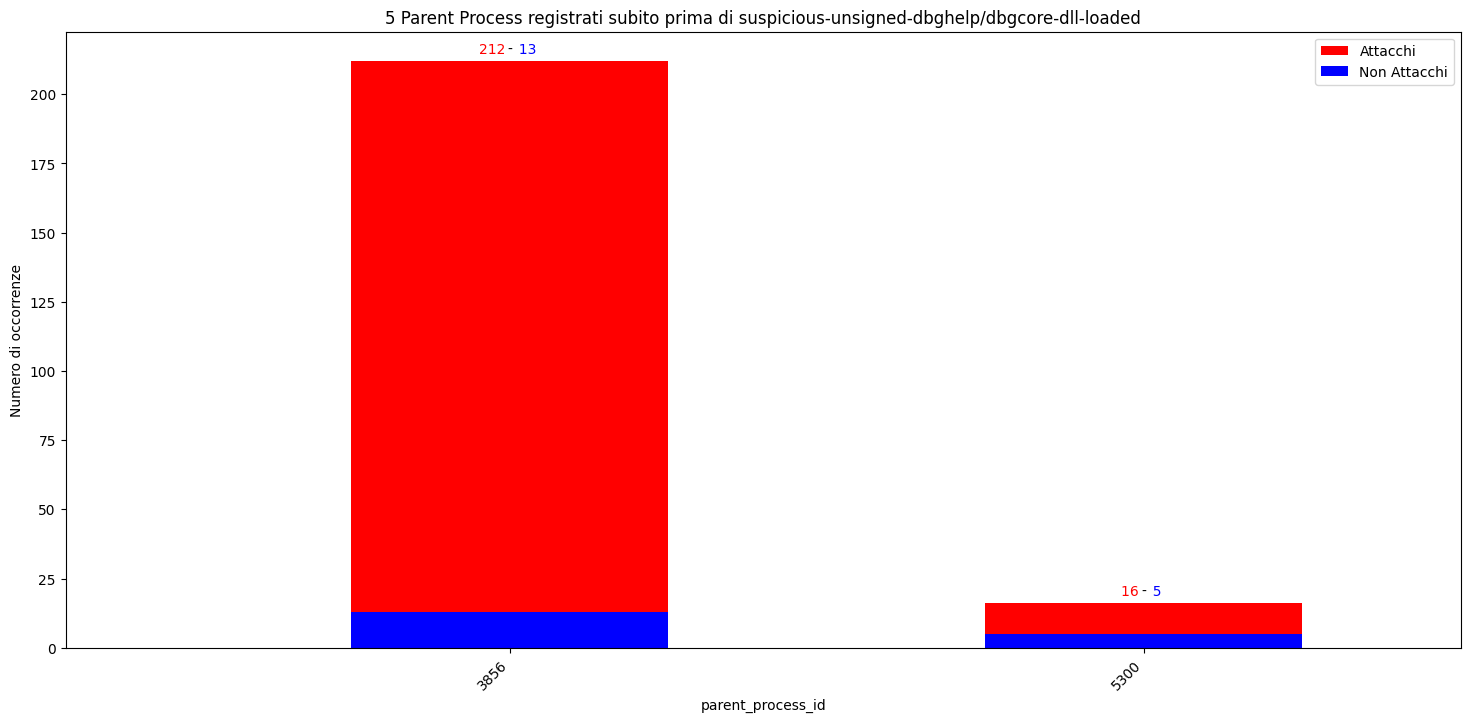

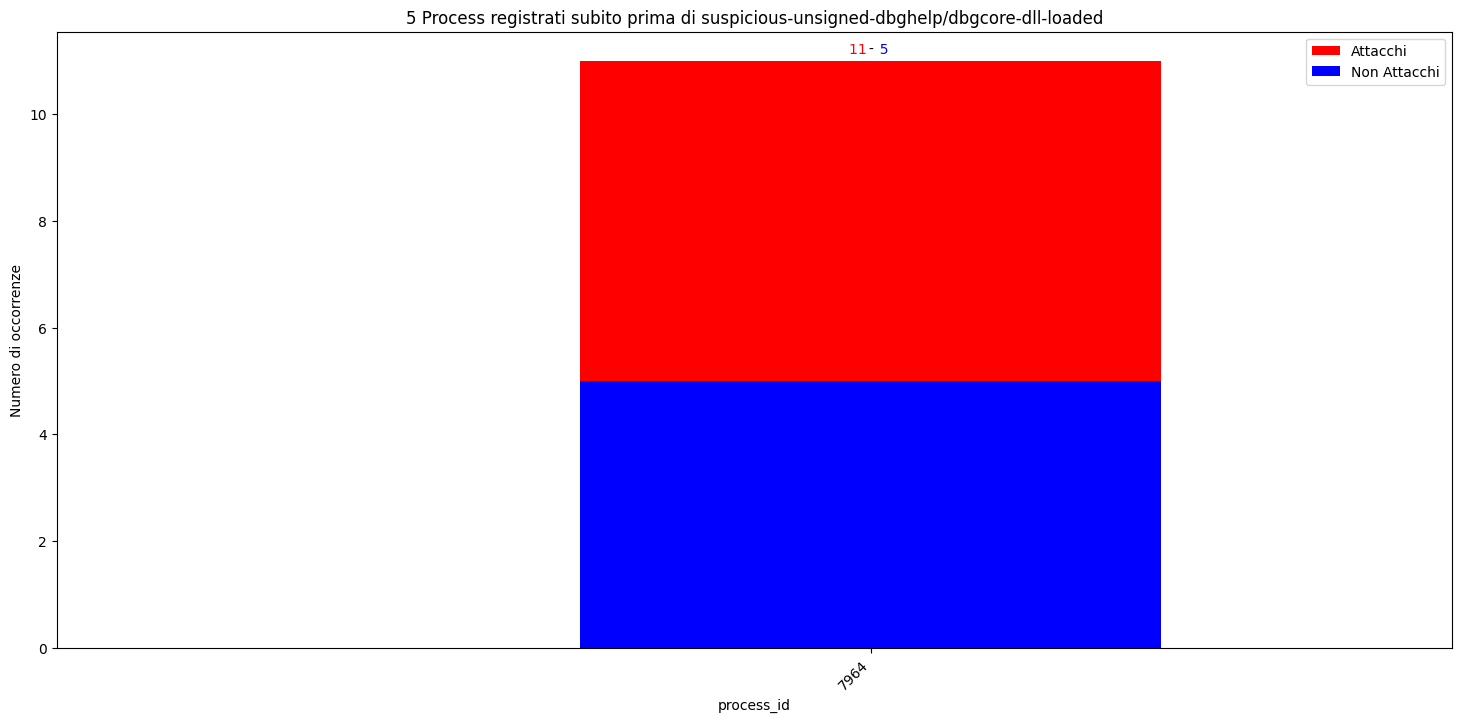

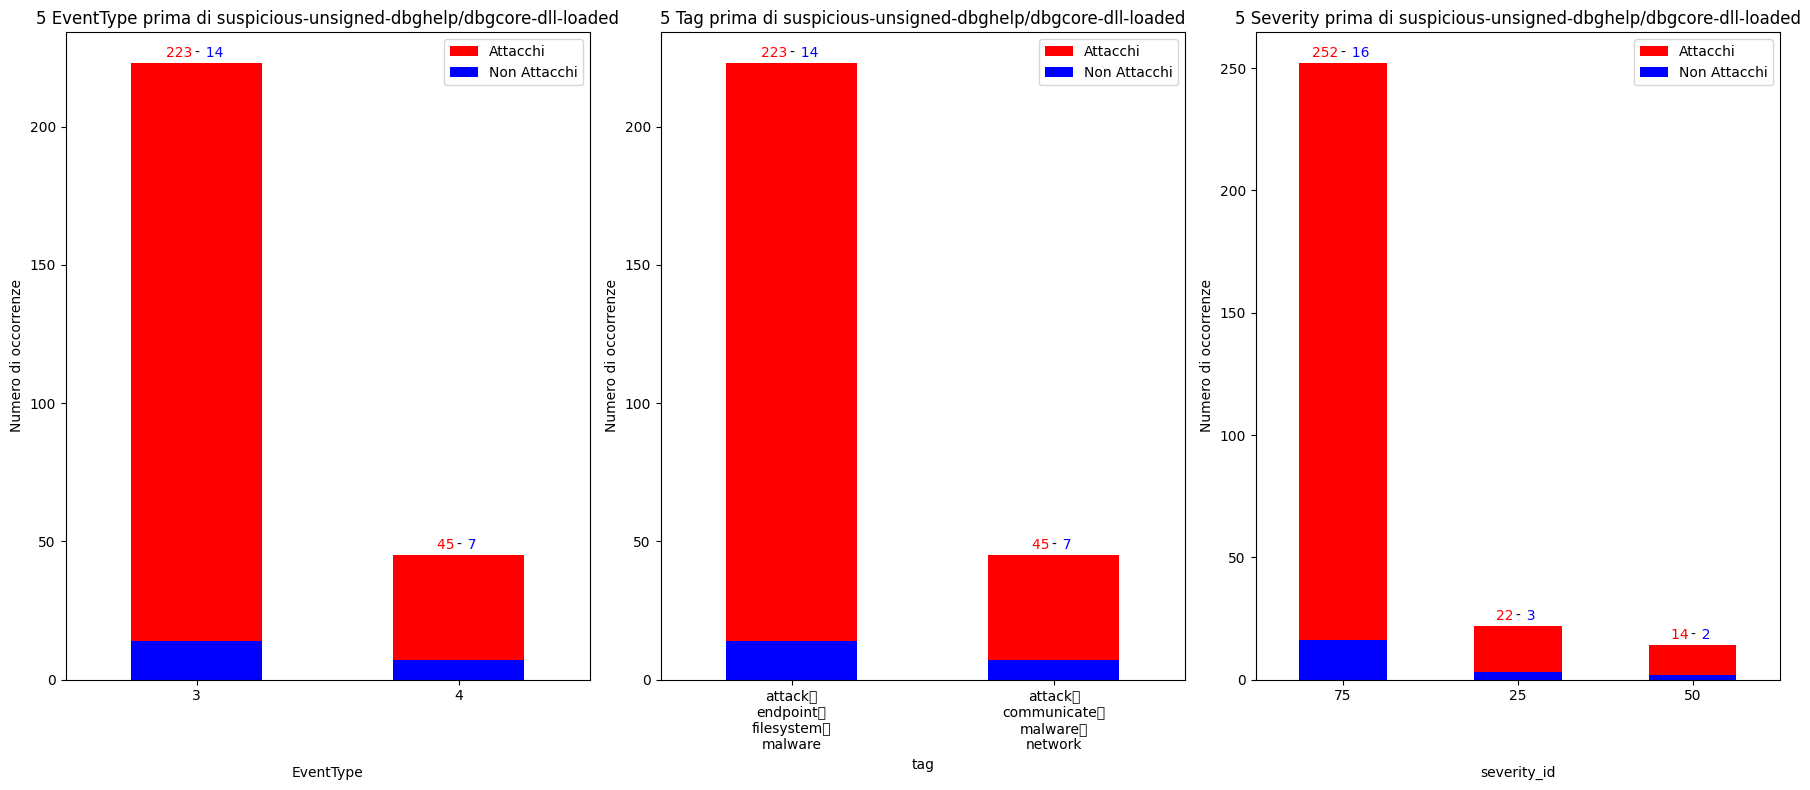

In [24]:
PlotsSingleAttack.patterns_before_activation(result_df_Raw, regola_scelta, eventi_da_considerare)

In questi grafici vediamo quali sono rispettivamente le *regole*, gli *attacchi*, gli *EventType*, i *tag*, i *parent_process*, i *process* e le *severity* degli eventi **subito prima** delle **prime attivazioni** della *regola scelta*.  
Il **numero di eventi da considerare** lo scegliamo affidando alla variabile *elementi_da_considerare* il numero che vogliamo.

Con "**prima attivazione di una regola**" si intende quando **almeno un elemento** delle colonne *signature, RuleAnnotation.mitre_attack.id, EventType, tag, severity_id, parent_process_id o process_id* (non sono considerate solo le colonne _time e corrisponde_ad_attacco) *di un evento* **differisce** da quello *precedente*.

# Patterns

In [25]:
signature_patterns = SignaturePatterns.recognize_signatures_patterns(result_df_Raw)
signature_patterns

Pattern: ('proc-start-malicious-powershell-commandlets-processcreation', 'proc-start-malicious-powershell-commandlets-processcreation'), Frequenza: 252
Pattern: ('proc-start-malicious-powershell-commandlets-processcreation', 'proc-start-malicious-powershell-commandlets-processcreation', 'proc-start-malicious-powershell-commandlets-processcreation'), Frequenza: 248
Pattern: ('proc-start-malicious-powershell-commandlets-processcreation', 'proc-start-malicious-powershell-commandlets-processcreation', 'proc-start-malicious-powershell-commandlets-processcreation', 'proc-start-malicious-powershell-commandlets-processcreation'), Frequenza: 244
Pattern: ('proc-start-dumping-of-sensitive-hives-via-reg.exe', 'proc-start-dumping-of-sensitive-hives-via-reg.exe'), Frequenza: 26
Pattern: ('proc-start-dumping-of-sensitive-hives-via-reg.exe', 'proc-start-dumping-of-sensitive-hives-via-reg.exe', 'proc-start-dumping-of-sensitive-hives-via-reg.exe'), Frequenza: 25
Pattern: ('proc-start-dumping-of-sensiti

In `signature_patterns` vediamo le **sequenze di 3, 4 o 5 regole** in ordine da quella più a quella meno frequente **ripetutesi più volte** durante i vari *attacchi* e che **non compaiono mai** tra le sequenze di *falsi attacchi*

## With specified severity value

In [26]:
result_pattern_inside_attack = analyzer.pattern_inside_attack(severity_value=severity_value)
result_pattern_inside_attack

MITRE ATT&CK IDs:
1-digit repetitions:

2-digits sequences:
  ('T1036\r', 'T1036\r'): 1
  ('T1003.001', 'T1003.001'): 1

3-digits sequences:
  ('T1059.001', 'T1059', 'T1482\r'): 2
  ('T1003.001', 'T1003.001', 'T1003.001'): 2
  ('T1218.011', 'T1555.004', 'T1059.001'): 1
  ('T1003.001', 'T1003.001', 'T1106'): 1
  ('T1134.001\r', 'T1134.001\r', 'T1134.002'): 1
  ('T1003.002\r', 'T1003.002\r', 'T1003.002\r'): 1

SIGNATURES:
1-digit repetitions:

2-digits sequences:
  ('proc-start-process-memory-dump-via-comsvcs.dll', 'proc-start-process-memory-dump-via-comsvcs.dll'): 1
  ('suspicious-unsigned-dbghelp/dbgcore-dll-loaded', 'suspicious-unsigned-dbghelp/dbgcore-dll-loaded'): 1

3-digits sequences:
  ('proc-start-suspicious-powershell-download-and-execute-pattern', 'proc-start-powershell-download-and-execution-cradles', 'proc-start-malicious-powershell-commandlets-processcreation'): 2
  ('suspicious-unsigned-dbghelp/dbgcore-dll-loaded', 'suspicious-unsigned-dbghelp/dbgcore-dll-loaded', 'suspici

In `result_pattern_inside_attack` vediamo:
- '**1-digit repetitions**' che corrisponde alle **ripetizioni** di *mitre_attack.id* e *signature* in testa agli attacchi con un numero **massimo di 3** mitre o signature registrati;
- '**2-digits sequences**' che corrisponde alle **sequenze** di *mitre_attack.id* e *signature* in testa agli attacchi con un numero di mitre o signature **compreso tra 4 e 5**;
- '**3-digits sequences**' che corrisponde alle **sequenze** di *mitre_attack.id* e *signature* in testa agli attacchi con un numero di mitre o signature **maggiore di 5** (non compreso).

# Correlation Matrix

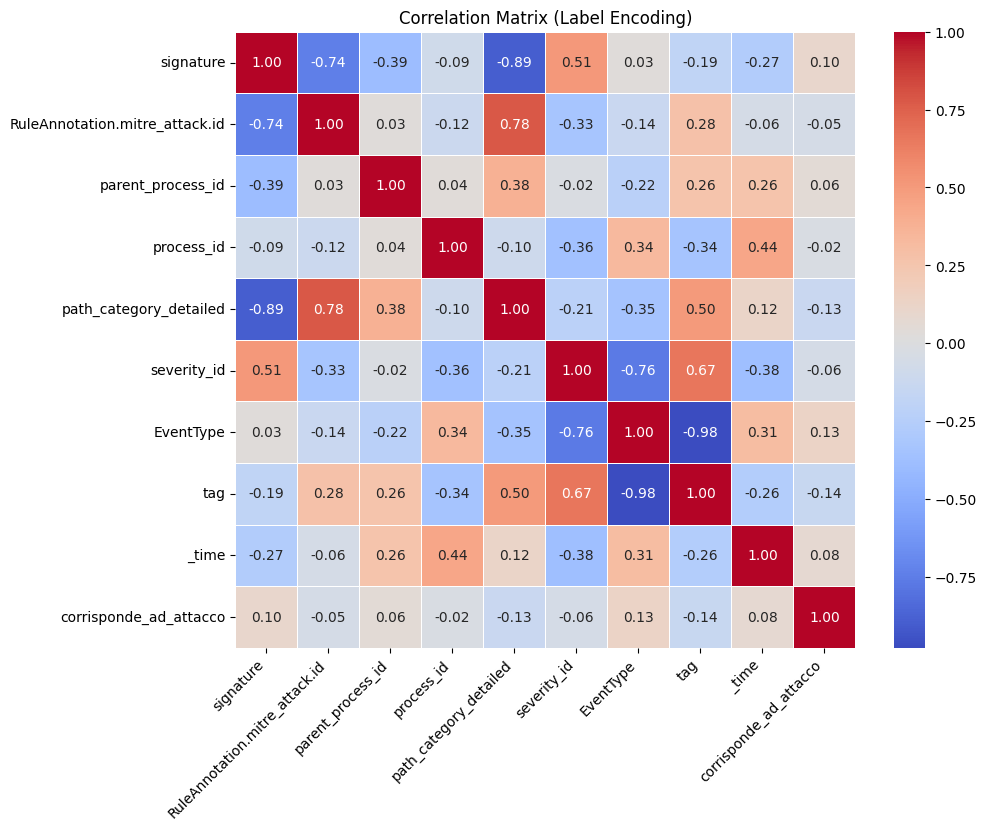

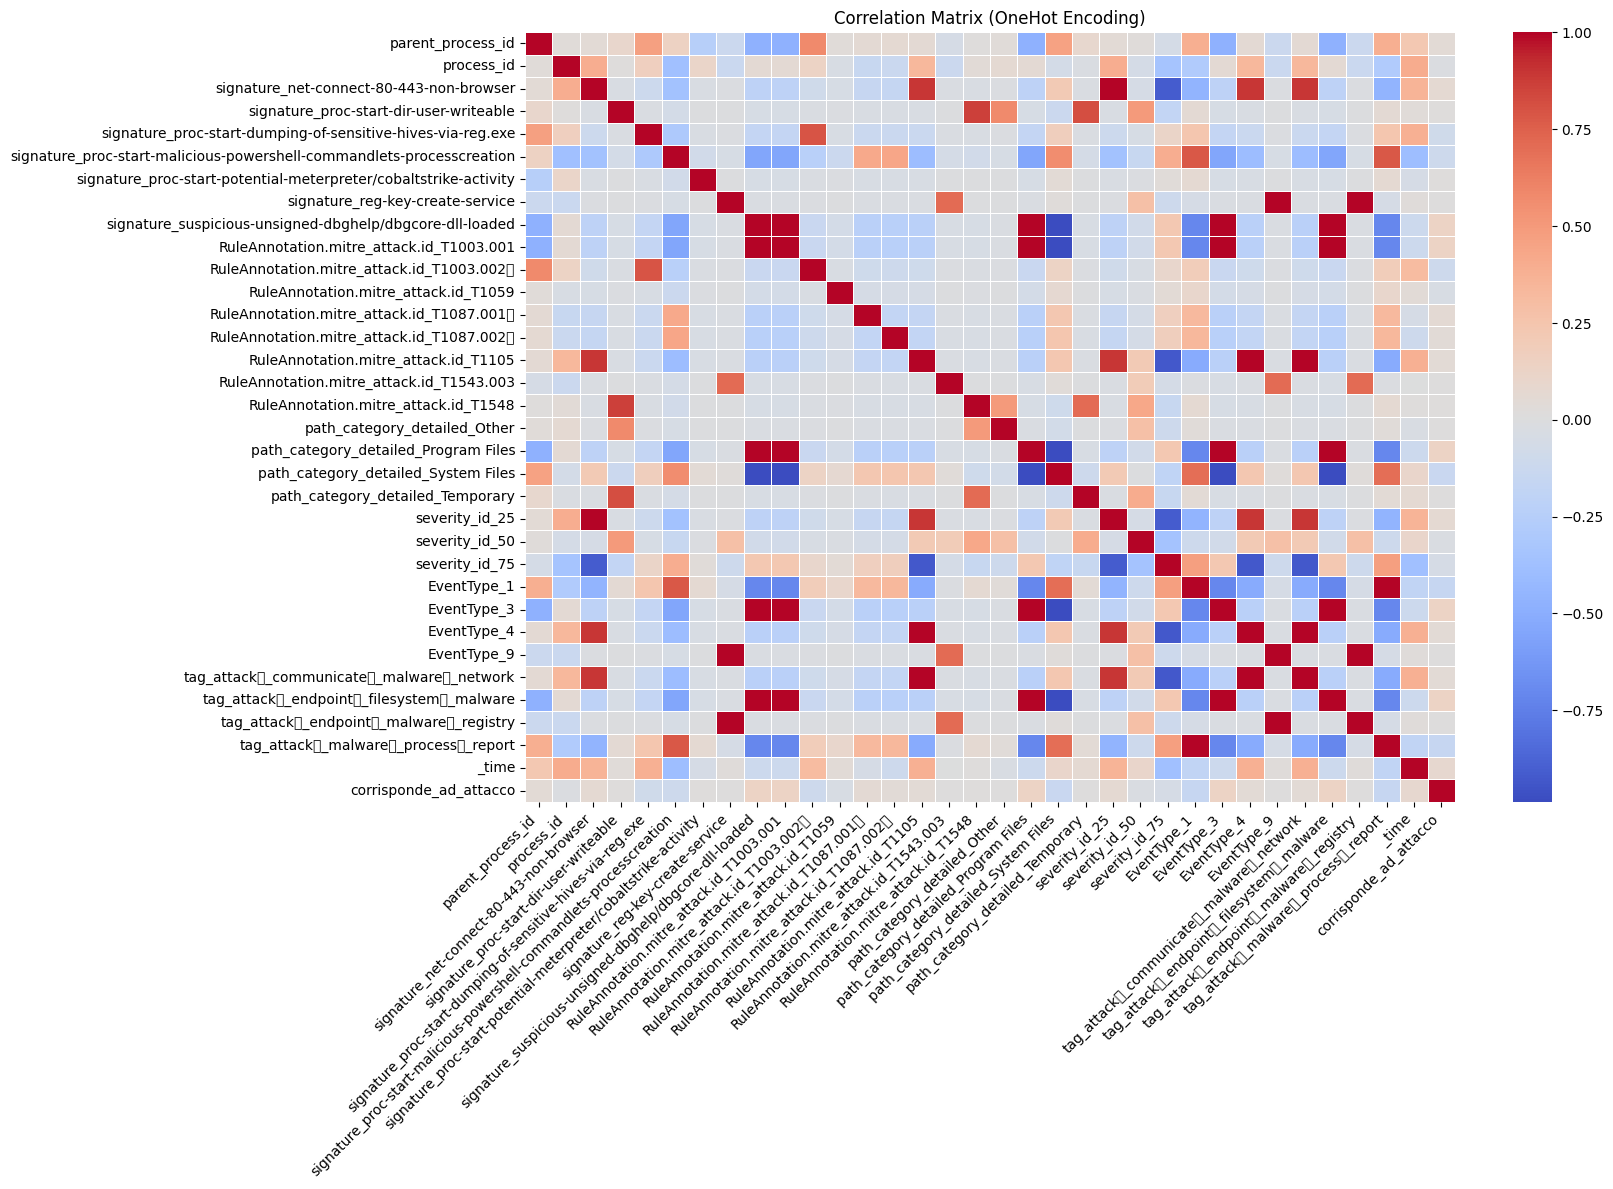

In [27]:
CorrelationMatrixPlots.plot_correlation_matrix(result_df_Le, 'Correlation Matrix (Label Encoding)')
CorrelationMatrixPlots.plot_correlation_matrix_big(result_df_OH, 'Correlation Matrix (OneHot Encoding)')

# ML

### OneHot

In [28]:
# Split data
X_train_OH, X_test_OH, y_train_OH, y_test_OH = PreprocessingTrainTestSplit.split_data(result_df_OH, "corrisponde_ad_attacco")

# Initial model training and evaluation
InitialTraining.train_and_evaluate_initial_models(X_train_OH, y_train_OH, X_test_OH, y_test_OH)

# Hyperparameter tuning
best_models_OH = HyperparameterTuning.tune_hyperparameters(X_train_OH, y_train_OH)

# Evaluate best models on test set
evaluator_OH = ModelEvaluator(best_models_OH)
evaluation_results_OH = evaluator_OH.evaluate_models(X_test_OH, y_test_OH)

# Train XGBoost model
AdvancedModels.train_xgboost(X_train_OH, y_train_OH, X_test_OH, y_test_OH)

# Train deep learning model
DeepLearningModel.train_deep_learning_model(X_train_OH, y_train_OH, X_test_OH, y_test_OH)


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.20      0.18         5
           1       0.97      0.97      0.97       145

    accuracy                           0.94       150
   macro avg       0.57      0.58      0.58       150
weighted avg       0.95      0.94      0.94       150


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.97      0.99      0.98       145

    accuracy                           0.95       150
   macro avg       0.48      0.49      0.49       150
weighted avg       0.93      0.95      0.94       150


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.97      0.99      0.98       145

    accuracy                           0.95       150
   macro avg       0.48  

<Sequential name=sequential, built=True>

### Label

In [29]:
# Split data
X_train_Le, X_test_Le, y_train_Le, y_test_Le = PreprocessingTrainTestSplit.split_data(result_df_Le, "corrisponde_ad_attacco")

# Initial model training and evaluation
InitialTraining.train_and_evaluate_initial_models(X_train_Le, y_train_Le, X_test_Le, y_test_Le)

# Hyperparameter tuning
best_models_Le = HyperparameterTuning.tune_hyperparameters(X_train_Le, y_train_Le)

# Evaluate best models on test set
evaluator_Le = ModelEvaluator(best_models_Le)
evaluation_results_Le = evaluator_Le.evaluate_models(X_test_Le, y_test_Le)

# Train XGBoost model
AdvancedModels.train_xgboost(X_train_Le, y_train_Le, X_test_Le, y_test_Le)

# Train deep learning model
DeepLearningModel.train_deep_learning_model(X_train_Le, y_train_Le, X_test_Le, y_test_Le)


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.40      0.33         5
           1       0.98      0.97      0.97       145

    accuracy                           0.95       150
   macro avg       0.63      0.68      0.65       150
weighted avg       0.96      0.95      0.95       150


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.97      0.99      0.98       145

    accuracy                           0.95       150
   macro avg       0.48      0.49      0.49       150
weighted avg       0.93      0.95      0.94       150


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.97      0.99      0.98       145

    accuracy                           0.95       150
   macro avg       0.48  

<Sequential name=sequential_1, built=True>

In [30]:
evaluator_OH.print_best_model('OneHot Encoder')
evaluator_Le.print_best_model('Label Encoder')


Dopo la codifica con OneHot Encoder il modello migliore è stato KNN con lo score di 0.7931

Dopo la codifica con Label Encoder il modello migliore è stato KNN con lo score di 0.8716
